In [1]:
import pandas as pd


%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
plt.style.use('mike')
jtplot.style(context='notebook', fscale=1, grid=False,ticks=True)

from betagen import betagen
dark, dark_highlight, mid, mid_highlight, light, light_highlight = betagen('#09837C') 

from astropy.cosmology import Planck15 as cosmo
import stan_utility

In [2]:
jla_data_set = pd.read_table('jla_lcparams.txt')

/Users/jburgess/.environs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [3]:
snls = jla_data_set['set'] == 1
sdss = jla_data_set['set'] == 2
lowz = jla_data_set['set'] == 3
hst  = jla_data_set['set'] == 4

<IPython.core.display.Javascript object>


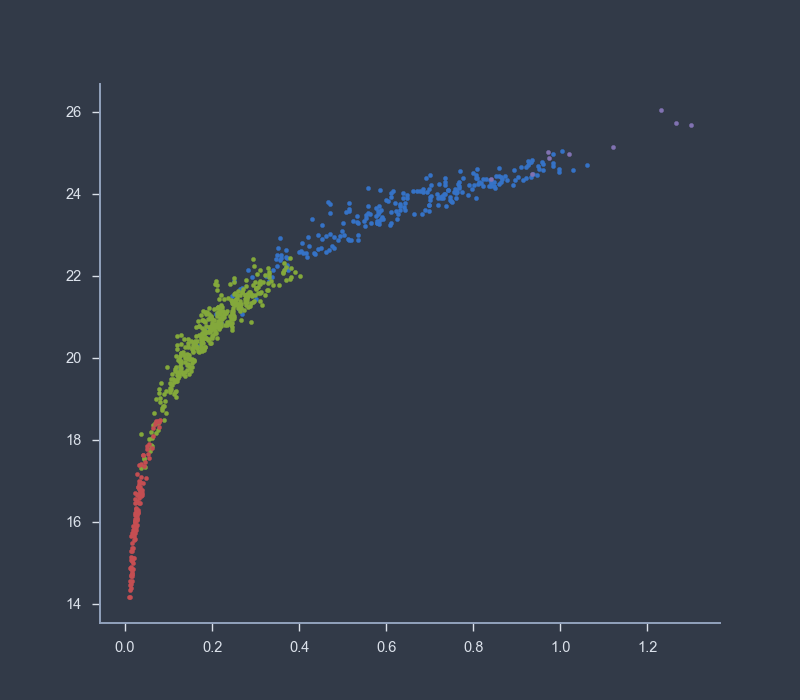

In [4]:
fig, ax = plt.subplots()

for ds in [snls, sdss, lowz, hst]:
    
    ax.scatter(jla_data_set.zcmb[ds], jla_data_set.mb[ds],s=10)
    
    
    

<IPython.core.display.Javascript object>


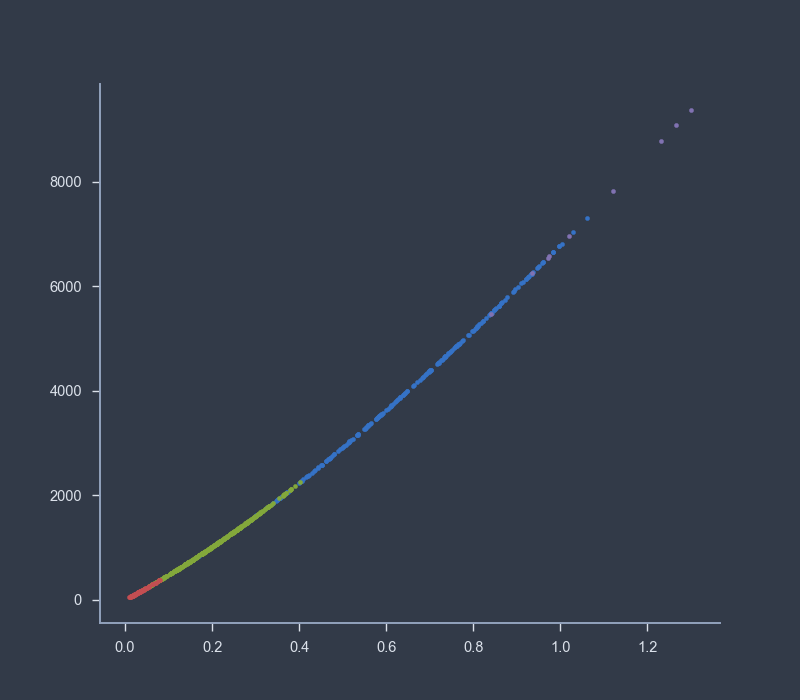

In [5]:
fig, ax = plt.subplots()

for ds in [snls, sdss, lowz, hst]:
    
    ax.scatter(jla_data_set.zcmb[ds],cosmo.luminosity_distance(jla_data_set.zcmb[ds]),s=10)
    
    
    

In [6]:
model = stan_utility.compile_model?

In [31]:
model = stan_utility.compile_model('supernove_model.stan','sn_cosmo');

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sn_cosmo_d366d88f93804a7feb8719f5eb1c8c7a NOW.


In [32]:
data = {}
data['N_sn'] = len(jla_data_set)
data['h0'] = 70.
data['zcmb'] = np.array(jla_data_set['zcmb'])

data['c_obs'] = np.array(jla_data_set['color'])
data['c_sigma'] = np.array(jla_data_set['dcolor'])

data['x1_obs'] = np.array(jla_data_set['x1'])
data['x1_sigma'] = np.array(jla_data_set['dx1'])

data['m_obs'] = np.array(jla_data_set['mb'])
data['m_sigma'] = np.array(jla_data_set['dmb'])


In [36]:
n_warmup=1000
n_samp = 250
iter = n_warmup + n_samp
n_chain = 4

fit = model.sampling(
    data=data,
    iter=iter,
    warmup=n_warmup,
    chains=n_chain,
    n_jobs=n_chain,
    thin=1,
    seed=1234,
    control=dict(max_treedepth=10, adapt_delta=0.85))

stan_utility.stanfit_to_hdf5(fit, 'sncosmo_fit.h5')


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<IPython.core.display.Javascript object>


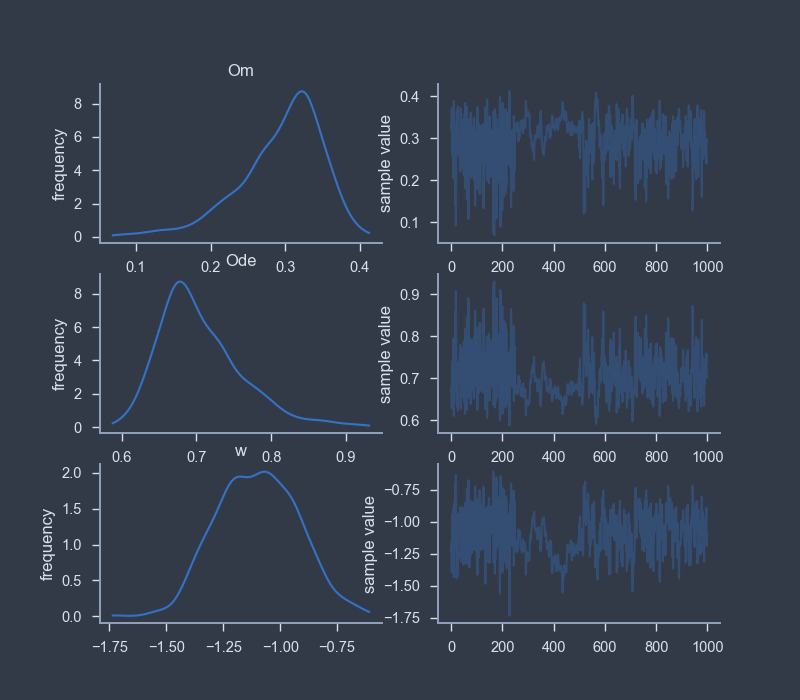

In [37]:
fit.plot(pars=['Om', 'Ode','w']);